In [1]:
import platform   
import math
import gym
import random
import os
import itertools

import matplotlib.pyplot as plt
import joblib
import numpy as np

from tqdm import tqdm

In [2]:
class QLearner:
    def __init__(self, params):
        self.environment = gym.make('LunarLander-v2')
        self.attempt_no = 1
        
        self.lower_bounds = (-1.0, -0.5, -2.0, -2.0, -1.5, -1.0, 0.0, 0.0)
        self.upper_bounds = (1.0, 2.0, 2.0, 0.5, 1.5, 1.0, 1.0, 1.0)

        self.q = {}
        self.buckets = params["buckets"]
        self.a = params["a"]
        self.y = params["y"]
        self.e = params["e"]
        
        self.a_m = params["a_m"]
        self.y_m = params["y_m"]
        self.e_m = params["e_m"]
        
        self.observations = []
        
        self.possible_actions = (0, 1, 2, 3)
        self.initial_value = 1000.0
        self.z = 0
        
    def learn(self, max_attempts):
        for _ in tqdm(range(max_attempts)):
            yield self.attempt()
        
            self.a *= self.a_m ** (1/max_attempts)
            self.y *= self.y_m ** (1/max_attempts)
            self.e *= self.e_m ** (1/max_attempts)
        
        print (self.z)


    def attempt(self):
        observation = self.discretise(self.environment.reset())
        done = False
        reward_sum = 0.0
        while not done:
            action = self.pick_action(observation)
            new_observation, reward, done, info = self.environment.step(action)

            new_observation =  self.discretise(new_observation)
            
            self.update_knowledge(action, observation, new_observation, reward)
            observation = new_observation
            reward_sum += reward
            
        self.attempt_no += 1
        return reward_sum

    def discretise(self, observation):
        res = []

        for (b, o, l, u) in zip(self.buckets, observation, self.lower_bounds, self.upper_bounds):
            clamp = lambda l, x, u: max(min(u, x), l)  

            r = b * clamp(0.0, (o - l) / (u - l), 0.9999)
            res.append(int(r))

        return tuple(res)

    def pick_action(self, observation):
        if random.random() < self.e:
            return random.choice(self.possible_actions)

        actions = [self.q.get((observation, i), self.initial_value) for i in self.possible_actions]
        return actions.index(max(actions))

    def update_knowledge(self, action, observation, new_observation, reward):
        new = reward + self.y * max(
            [self.q.get((new_observation, i), self.initial_value) for i in self.possible_actions]
        )
        self.q[(observation, action)] = (1 -self.a) * \
        self.q.get((observation, action), self.initial_value)  + self.a * new

memory = joblib.Memory(location=os.path.realpath('.'), verbose=0)


@memory.cache         
def learn(params, attempts):
    learner = QLearner(params)
    return list(learner.learn(attempts))

In [3]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

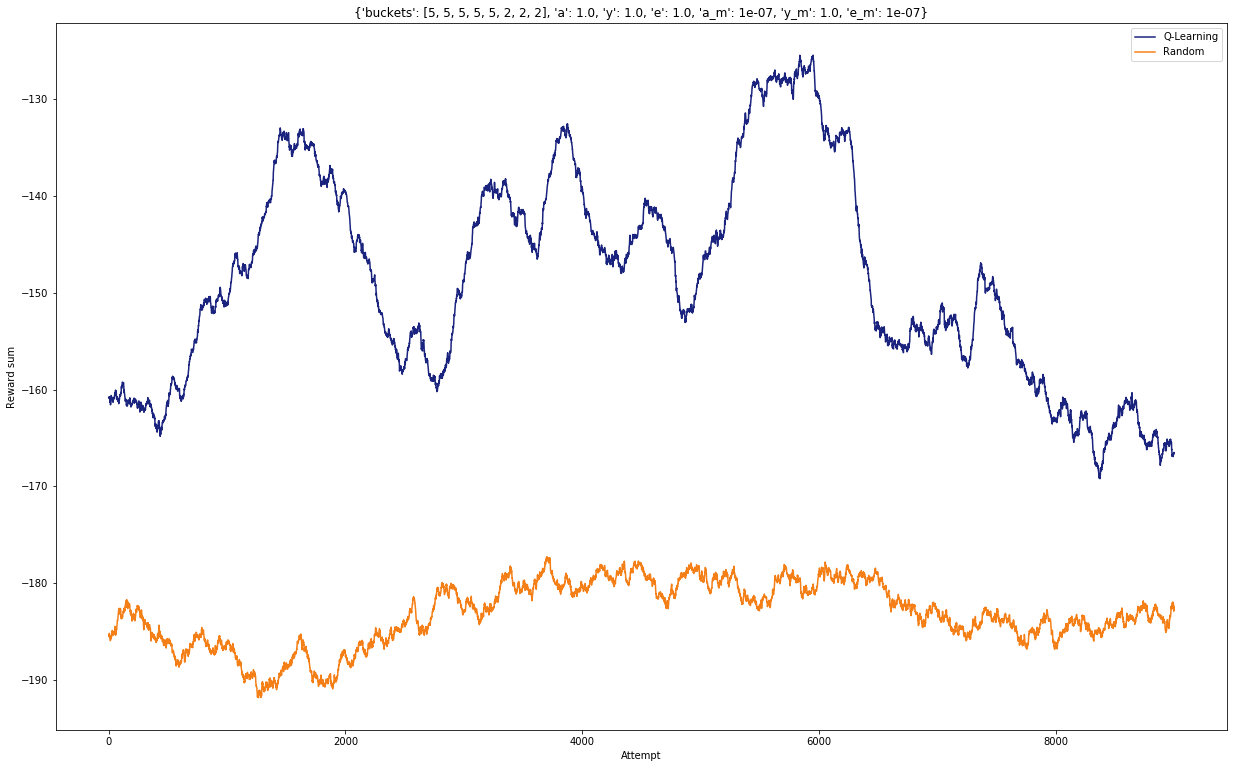

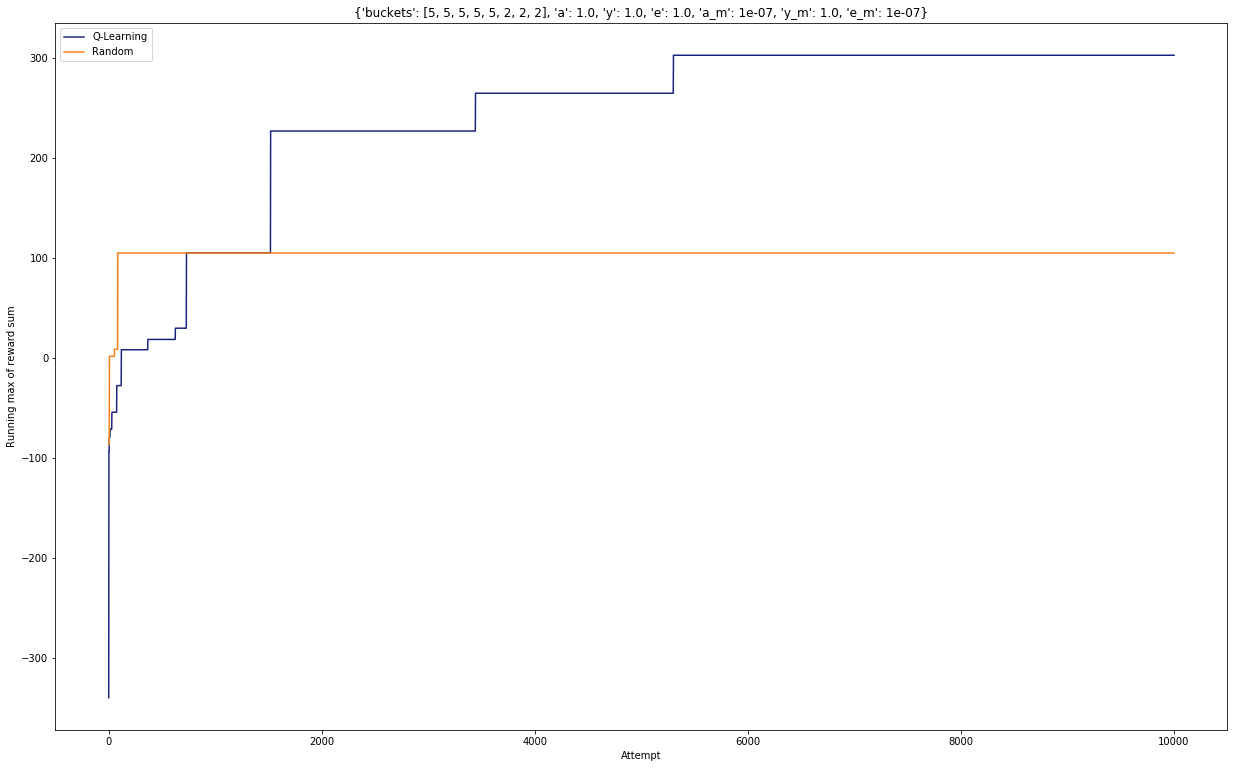

In [13]:
def run(params):
    learner = QLearner(params)
    
    attempts = 10000
    
    
    q_learning = learn(params, attempts)
    random = learn({**params, "e": 1.0, "e_m": 1.0}, attempts)
    
    q_learning_rm = running_mean(q_learning, 1000)
    random_rm = running_mean(random, 1000)



    x = list(range(1, len(random_rm) + 1))
    plt.figure(figsize=(21, 13))
    plt.plot(x, q_learning_rm, color="#1a237e", label="Q-Learning")
    plt.plot(x, random_rm, color="#f57f17", label="Random")
    plt.xlabel("Attempt")
    plt.ylabel("Reward sum")
    plt.legend()
    plt.title(str(params))
    plt.show()
    
    x = list(range(1, len(random) + 1))
    plt.figure(figsize=(21, 13))
    
    running_max = lambda x: np.maximum.accumulate(np.array(x))
    plt.plot(x, running_max(q_learning), color="#1a237e", label="Q-Learning")
    plt.plot(x, running_max(random), color="#f57f17", label="Random")
    plt.xlabel("Attempt")
    plt.ylabel("Running max of reward sum")
    plt.legend()
    plt.title(str(params))
    plt.show()

params = {
    "buckets": [5, 5, 5, 5, 5, 2, 2, 2],

    
    "a": 1.0,
    "y": 1.0,
    "e": 1.0,
    
    "a_m": 0.0000001,
    "y_m": 1.0,
    "e_m": 0.0000001
}

run(params)